# Feature Engineering

This notebook works with:

- Concatenated data from the 2 time periods of Planet and ERA-5 for filling the gap

  * Reads cleaned and concatenated data from Planet and ERA-5 
  * Calculates climatology for Soil Water Content
  * Calculates anomaly and negative anomaly

After those steps:
  * Stores the data as a NetCDF file


In [1]:
import sys
gp = '/home/jupyter-gabriel/'
sys.path.append(gp + "projects/suyana")
from scripts.utils.functions import *

In [2]:
def add_climatology(ds, field, time_dim = 'time', dims = None):
    # Get full years only to calculate the climatology
    # Group by year and count the number of dates
    ds_days_per_year = ds[time_dim].groupby(time_dim+".year").count()

    # Filter for full years
    full_years = ds_days_per_year.where(ds_days_per_year >= 365).dropna('year')
    ds_full = ds.sel(time=ds["time.year"].isin(full_years.year))
    
    if dims == None:
        dims = [time_dim]

    if not set(dims).issubset(set(list(ds.sizes.keys()))):
        raise ValueError(f"Input for dims must be a subset of dimensions")

    climatology = ds_full[field].groupby(time_dim+".dayofyear").mean(dims)
    ds["climatology"] = xr.DataArray(
        climatology.sel(dayofyear=ds[time_dim+".dayofyear"]), 
        dims=list(ds.sizes.keys())
    )

    return ds


In [3]:
def add_anomaly(ds, field):
    # ds["swc"] = ds["swc_adjusted"].rolling(time=21, min_periods=1).mean()
    # First value will not be filled if it is nan, so drop it
    if ds[field].isel(time=0).isnull().any():
        ds = ds.isel(time=slice(1, None))
    ds["anomaly"] = ds[field] - ds["climatology"]
    ds["negative_anomaly"] = ds["anomaly"].where(ds["anomaly"] < 0, np.nan) * (-1)
    ds["negative_anomaly"] = ds["negative_anomaly"].fillna(0)

    return ds

In [4]:
def add_crop_cycles(ds, time_dim):
    ds["crop_cycle"] = 2001 + (ds[time_dim].dt.year - 2002) + (ds[time_dim].dt.month >= 11)
    mask_feb = (ds[time_dim].dt.month == 2) & (ds[time_dim].dt.day >= 16)
    mask_mar_oct = (ds[time_dim].dt.month >= 3) & (ds[time_dim].dt.month <= 10)
    mask = mask_feb | mask_mar_oct
    ds["crop_cycle"] = ds["crop_cycle"].where(~mask)
    ds = ds.set_coords("crop_cycle")
    return ds


In [5]:
def add_crop_cycles(ds, time_dim):
    # Add a crop_year coordinate and a flag of summer campaign
    ds["crop_year"] = (ds[time_dim] - np.timedelta64(4, 'm')).dt.year
    ds["flag_summer"] = xr.where(ds[time_dim].dt.month.isin([11,12,1,2,3,4]),1,0)

    # Add a crop_cycle coordinate
    ds["crop_cycle"] = 2001 + (ds[time_dim].dt.year - 2002) + (ds[time_dim].dt.month >= 11)
    mask_feb = (ds[time_dim].dt.month == 2) & (ds[time_dim].dt.day >= 16)
    mask_mar_oct = (ds[time_dim].dt.month >= 3) & (ds[time_dim].dt.month <= 10)
    mask = mask_feb | mask_mar_oct
    ds["crop_cycle"] = ds["crop_cycle"].where(~mask)

    ds = ds.set_coords(["crop_year", "flag_summer", "crop_cycle"])
    return ds


# Create anomaly and climatology for each dataset

In [6]:
# Read the yields panel dataset to clean only the required values of canton
df_yields_final = pd.read_csv(gp+'projects/suyana/data/drought/yields_panel_id.csv')

In [7]:
import os
path = gp+"/suyana/drought/swc/raw/"
files = os.listdir(path)
files = [f for f in files if f.startswith("canton")]
id_canton = [files[i].split("_")[1] for i in range(len(files))]

list_ids = sorted(list(set(df_yields_final['id_canton'].astype(str)).intersection(set(id_canton))))
list_ids

['189', '195', '209', '43', '49', '52', '54', '56', '57']

In [8]:
for id in list_ids:
    print(f"Canton: {id}")

    ds = xr.open_dataset(gp + 'projects/suyana/data/capacity/canton_processed_' + str(id) + '.nc')

    ds = add_climatology(ds, 'swc_adjusted')
    ds = add_anomaly(ds, 'swc_adjusted')
    ds = add_crop_cycles(ds, 'time')
    print('Climatology and anomaly successfully added')

    comp = dict(zlib=True, complevel=9)
    encoding = {var: comp for var in ds.data_vars}
    
    ds.to_netcdf(
        gp + '/projects/suyana/data/capacity/canton_coarsened_' + str(id) +'.nc',
        encoding = encoding
    )

Canton: 189
Climatology and anomaly successfully added
Canton: 195
Climatology and anomaly successfully added
Canton: 209
Climatology and anomaly successfully added
Canton: 43
Climatology and anomaly successfully added
Canton: 49
Climatology and anomaly successfully added
Canton: 52
Climatology and anomaly successfully added
Canton: 54
Climatology and anomaly successfully added
Canton: 56
Climatology and anomaly successfully added
Canton: 57
Climatology and anomaly successfully added


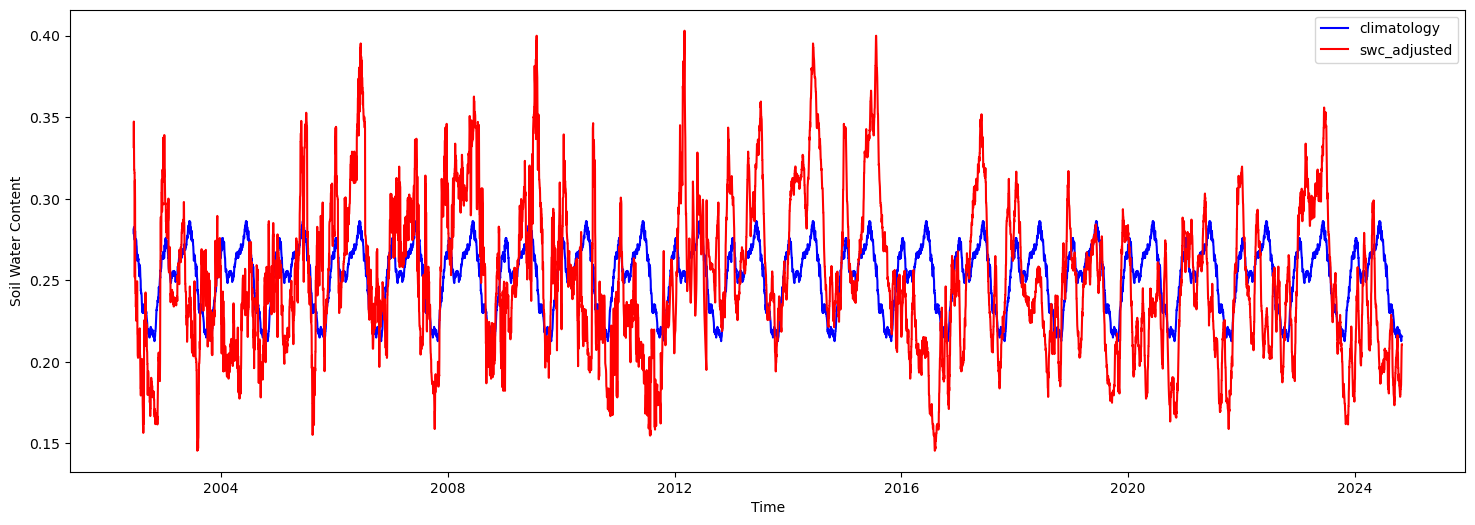

In [97]:
# Select the data at the specific location
ds_location = ds.isel(lon=0, lat=13)
#ds_location = ds_location.sel(time=slice('2010-10-01', '2013-07-31'))
# Plotting 
plt.figure(figsize=(18, 6)) 
plt.plot(ds_location.time, ds_location.climatology, label='climatology', color='blue') 
plt.plot(ds_location.time, ds_location.swc_adjusted, label='swc_adjusted', color='red')
plt.xlabel('Time') 
plt.ylabel('Soil Water Content')
plt.legend()
plt.show()

In [33]:
ds_aux= ds_location.sel(time=ds_location['time.dayofyear'].isin(list(np.arange(260,280))))

In [34]:
ds_aux.swc_adjusted.values

array([0.23174359, 0.23174359, 0.23194872, 0.24071429, 0.24052778,
       0.23662222, 0.17615385, 0.17659524, 0.17494444, 0.17659524,
       0.18138462, 0.17838462, 0.17886111, 0.17787179, 0.17579487,
       0.17505128, 0.17630769, 0.17630769, 0.17512821, 0.17402564,
       0.1735641 , 0.1735641 , 0.16223077, 0.20542222, 0.19964444,
       0.1957963 , 0.24158333, 0.23833333, 0.23641026, 0.23641026,
       0.24679487, 0.24679487, 0.26217949, 0.2635    , 0.268     ,
       0.27351282, 0.2747381 , 0.27616667, 0.27616667, 0.27580952,
       0.278     , 0.27958974, 0.28372222, 0.27725641, 0.28635897,
       0.28635897])

# Create climatology and anomaly from nearest pixel

In [87]:
# Step 1: Function to select nearest points
def select_nearest(ds, df):
    """
    Selects nearest points from the xarray.Dataset for each (lon, lat) in the DataFrame.
    """
    results = []
    for _, row in df.iterrows():
        # Select the nearest point
        nearest_point = ds.sel(lon=row["longitude"], lat=row["latitude"], method="nearest")
        results.append(nearest_point)
    return results

In [88]:
# Read the yields panel dataset to clean only the required values of canton
df_yields_final = pd.read_csv(gp+'projects/suyana/data/drought/yields_panel_id.csv')

In [89]:
# Clean up date data
df_yields_final = df_yields_final.loc[~((df_yields_final.harvest_date.isna())),:].copy()

df_yields_final['harvest_date'] = pd.to_datetime(df_yields_final['harvest_date'])
df_yields_final['seed_date'] = pd.to_datetime(df_yields_final['seed_date'])

df_yields_final['crop_year'] = df_yields_final.yr
df_yields_final['flag_summer'] = df_yields_final.summer

In [90]:
df_coords = df_yields_final[['longitude', 'latitude','id_lot', 'id_canton']].drop_duplicates(
    subset=['longitude', 'latitude', 'id_canton'], keep='first'
)
list_ids = sorted(df_coords['id_canton'].unique().tolist())
list_ids

[43, 49, 52, 54, 56, 57, 189, 195, 209]

In [91]:
df = pd.DataFrame()
for id in list_ids:
    print(f"Canton: {id}")
    df_aux = df_coords[df_coords['id_canton']==id].copy()
    ds_canton = xr.open_dataset(gp + '/projects/suyana/data/capacity/canton_coarsened_' + str(id) +'.nc')
    ds_nearest = select_nearest(ds_canton, df_aux)
    df_result = pd.DataFrame({
        "id_lot": df_aux["id_lot"],
        "lon": df_aux["longitude"],
        "lat": df_aux["latitude"],
        "id_canton": df_aux["id_canton"],
        "nearest_lon": [point.lon.values for point in ds_nearest],
        "nearest_lat": [point.lat.values for point in ds_nearest],
        "time": [point.time.values for point in ds_nearest],
        "crop_year": [point.crop_year.values for point in ds_nearest],
        "flag_summer": [point.flag_summer.values for point in ds_nearest],
        "swc_adjusted": [point.swc_adjusted.values for point in ds_nearest],
        "climatology": [point.climatology.values for point in ds_nearest],
        "anomaly": [point.anomaly.values for point in ds_nearest],
        "negative_anomaly": [point.negative_anomaly.values for point in ds_nearest],
    })
    df_result = df_result.explode(['time', 'crop_year', 'flag_summer','swc_adjusted', 'climatology', 'anomaly', 'negative_anomaly'], ignore_index= True)
    df = pd.concat([df, df_result], axis=0)

Canton: 43
Canton: 49
Canton: 52
Canton: 54
Canton: 56
Canton: 57
Canton: 189
Canton: 195
Canton: 209


In [83]:
df_final = df.copy()

In [ ]:
df_final.to_parquet(gp + '/projects/suyana/data/drought/anomalies.parquet', compression='gzip')

In [ ]:
df_final = pd.read_parquet(gp + '/projects/suyana/data/drought/anomalies.parquet')
df_final.head(4)

In [92]:
# Get the nearest anomaly crop cycle
df_anomalies = df_final.groupby(['lon', 'lat', 'crop_year', 'flag_summer']).agg(
    accum_cycle_neg_anomaly = ('negative_anomaly', 'sum'),
    accum_cycle_anomaly = ('anomaly', 'sum'),
).reset_index()
df_anomalies.head(3)

,lon,lat,crop_year,flag_summer,accum_cycle_neg_anomaly,accum_cycle_anomaly
0,-63.48737,-16.36514,2002,0,6.711689,-6.711689
1,-63.48737,-16.36514,2002,1,1.411225,-0.904553
2,-63.48737,-16.36514,2003,0,4.225493,-3.536853


In [93]:
df_yields_final.shape

(710, 95)

In [94]:
# Add anomalies to yields data
df_aux = df_yields_final[['longitude','latitude', 'crop_year', 'flag_summer', 'harvest_date', 'seed_date']].copy()
df_join = df_aux.merge(
    df_final[['lon', 'lat', 'anomaly', 'negative_anomaly', 'time']],
    how = "left",
    left_on = ["longitude", "latitude"],
    right_on = ["lon", "lat"]
).drop(['lon', 'lat'], axis = 1)

df_join = df_join.query(
    "time >= seed_date & time <= harvest_date"
)

#df_join = df_join.sort_values(by='time', axis=1)
df_join = df_join.groupby(['longitude', 'latitude', 'crop_year', 'flag_summer']).agg(
    accum_anomaly = ('anomaly', 'sum'),
    accum_neg_anomaly = ('negative_anomaly', 'sum')
).reset_index()

df_yields_final = df_yields_final.merge(
    df_join,
    how = 'left',
    on = ['longitude', 'latitude', 'crop_year', 'flag_summer']
)

df_yields_final = df_yields_final.merge(
    df_anomalies,
    how = 'left',
    left_on = ['longitude', 'latitude', 'crop_year', 'flag_summer'],
    right_on = ['lon', 'lat', 'crop_year', 'flag_summer'],
)

#df_yields_final[['longitude', 'latitude', 'seed_date', 'harvest_date', 'accum_anomaly', 'accum_neg_anomaly', 'accum_cycle_neg_anomaly', 'accum_cycle_anomaly']].head(3)

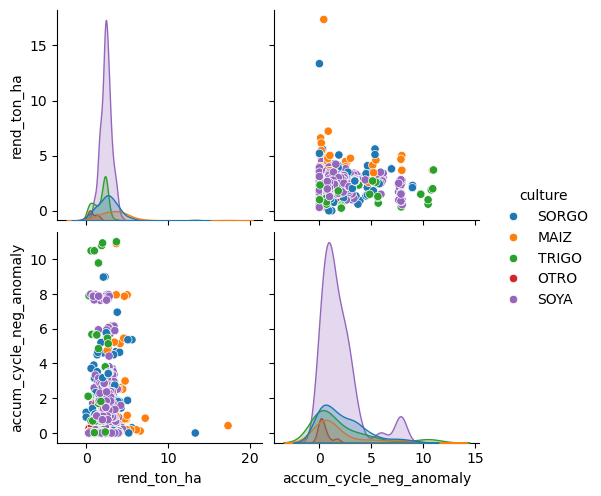

In [95]:
sns.pairplot(
    df_yields_final.loc[df_yields_final['flag_summer'].isin([0,1]),['rend_ton_ha', 'accum_cycle_neg_anomaly','culture']], 
    hue='culture'
)

In [96]:
df_yields_final.to_csv(gp + 'projects/suyana/data/drought/yields_panel_final.csv', index=False)